In [ ]:
from keras.datasets import boston_housing

In [ ]:
(train_data, train_targets), (test_data, test_target) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [ ]:
train_data.shape

(404, 13)

In [ ]:
#normalisation des donnees
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


In [ ]:
#definition du model
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  #mae(mean absolute error), valeur absolue de la differencence entre les predictions et les etiquettes
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model

In [ ]:
# validation croisee a K-fold
#lorsqu'on a peu de points de donnees, l'ensemble de validation devient tres petit

import numpy as np

k = 4
#on divise l'ensemble de donnees en k partitions
# on met deux barres pour convertir en int directement
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []
print(num_val_samples)

#pour chaque partition
for i in range(k):
  print("processing fold #,", i)
  # preparation des donnes de validation provenant de la partition K
  val_data = train_data[i * num_val_samples: (i+1)* num_val_samples]
  val_target = train_targets[i * num_val_samples: (i+1)* num_val_samples]
 
  #preparation des donnees d'apprentissage, provenant de toutes les partitions sauf celle de K

  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)

  #construction du modele deja compile
  model = build_model()

  #entraienement du model en mode silencieu (verbose = 0)

  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_target),
                      epochs=num_epochs, batch_size=1, verbose=0)

  mae_history = history.history['val_mae']
  history.history.keys()
  #evaluation du  model sur les donnees de validation
  #val_mse, val_mae = model.evaluate(val_data, val_target, verbose=0)

  all_mae_histories.append(mae_history)

  all_mae_histories


101
processing fold #, 0
processing fold #, 1
processing fold #, 2
processing fold #, 3


In [ ]:
len(all_mae_histories)

4

In [ ]:
#calcul de la moyenne des scores MAE par epoque pour chaque fold
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
len(average_mae_history)

500

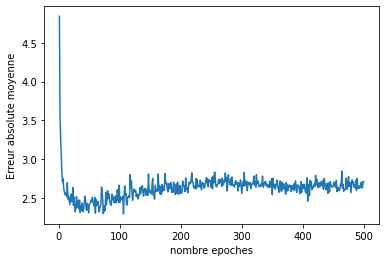

In [ ]:
#tracee des scores de validation
import matplotlib.pyplot as plt 

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("nombre epoches")
plt.ylabel("Erreur absolute moyenne")
plt.show()

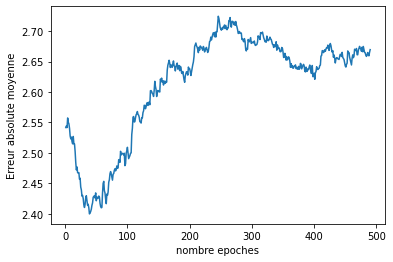

In [ ]:
#traitement a effectuer car graphique difficile a interpreter
#enlever les 10 premiers point de donnees exprimees a une echelle de valeurs differentes
#remplacement de chaque point par une moyenne exponentielle des points precedents pour obtenir une courbe lisse

def smooth_curve(points, factor = 0.9):
  smoothed_points  = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("nombre epoches")
plt.ylabel("Erreur absolute moyenne")
plt.show()

In [ ]:
#entrainement du model final

model = build_model()

model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_target)

test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 19.0863 - mae: 2.6872


2.687244415283203